

# Lecture 17: Quantum Phase Estimation

In [1]:
# Import usual python numerical library
import numpy as np
# Importing standard Qiskit libraries
from qiskit import *

%matplotlib inline

In [ ]:
import subprocess

#this is so I can run the code on my computer without sharing my token online
#you can get your own token at https://quantum-computing.ibm.com/account
token = subprocess.run("echo $IBM_TOKEN", shell=True, stdout=subprocess.PIPE).stdout.decode('utf-8').strip()
# for the bots out there, I invalitdated the toke I accedentally shared

In [ ]:
# Insert your token
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
  token=token,channel="ibm_quantum", # `channel` distinguishes between different account types
  overwrite=True, set_as_default=True)


In [ ]:
from qiskit_ibm_runtime import SamplerV2
from qiskit.visualization import *

In [8]:
# Find backends available AND currently operational through IBMQ and print 
# the number of pending jobs to see how busy they are:

service = QiskitRuntimeService(channel="ibm_quantum")

for backend in service.backends(operational = True):    
    print(backend.name, ', n_qubits =', backend.configuration().n_qubits, 
          ', pending_jobs =', backend.status().pending_jobs)
    

ibm_brisbane , n_qubits = 127 , pending_jobs = 65
ibm_kyiv , n_qubits = 127 , pending_jobs = 3
ibm_sherbrooke , n_qubits = 127 , pending_jobs = 2


In [9]:
from qiskit_aer import AerSimulator

In [10]:
# This sets a simulator and a real device for you to work with. Feel free to choose a different real device by 
# checking if it's less busy.
backend_simulator = AerSimulator()
backend_brisbane = service.backend("ibm_brisbane")
backend_kyiv = service.backend("ibm_kyiv")


# Quantum Phase estimation



In [11]:
# circuit with |+i> input
circ_qpe = QuantumCircuit(2, 2)
# prepare |+i> state:
circ_qpe.h(0)
circ_qpe.s(0)
circ_qpe.barrier(range(2))
# circuit:
circ_qpe.h(1)
circ_qpe.cy(1,0)
circ_qpe.h(1)
#
circ_qpe.barrier(range(2))
circ_qpe.measure(1,1)
# This finishes the circuit. Now let's add a unitary that takes |+i> into |0>, and measure:
circ_qpe.barrier(range(2))
circ_qpe.sdg(0)
circ_qpe.h(0)
circ_qpe.measure(0,0)
#
circ_qpe.draw(reverse_bits=True, output="latex")



MissingOptionalLibraryError: "The 'pdflatex' library is required to use 'LaTeX circuit drawing'.  You will likely need to install a full LaTeX distribution for your system."

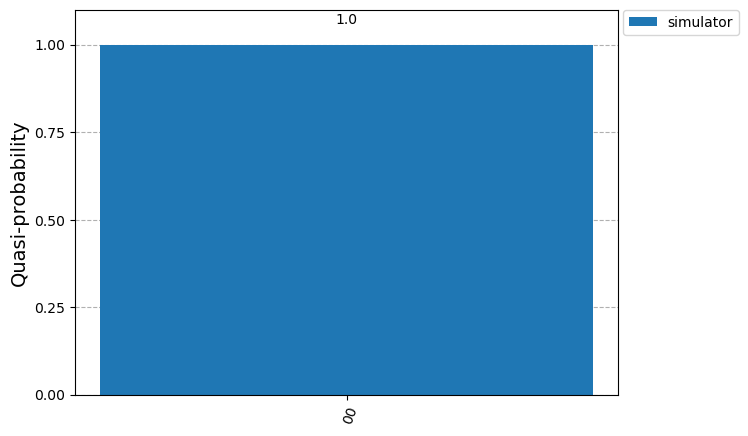

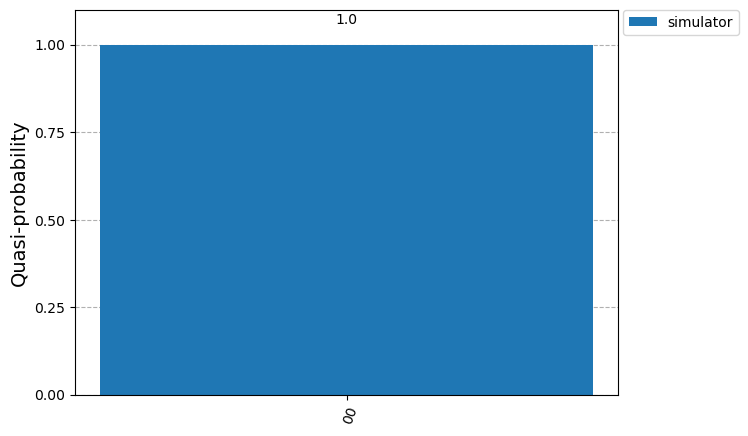

In [ ]:
# Execute on local simulator for input with |+i>

job_simulator = backend_simulator.run(circ_qpe, shots=10000)
result_simulator = job_simulator.result()

counts_simulator = result_simulator.get_counts(circ_qpe)
plot_distribution([counts_simulator], legend=['simulator'])


In [ ]:
# Submit job to real device. Remember we have to transpile first

pm = generate_preset_pass_manager(backend=backend_brisbane, optimization_level=1)
isa_circ_qpe = pm.run(circ_qpe)
from qiskit_ibm_runtime import SamplerV2
sampler = SamplerV2(backend_brisbane)
job_brisbane1 = sampler.run([isa_circ_qpe])


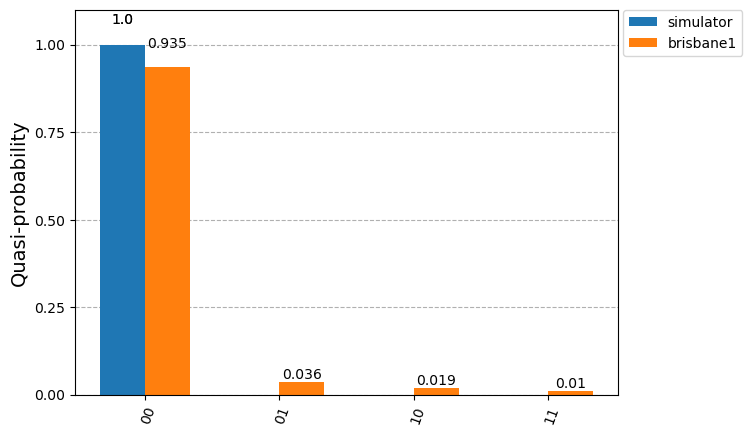

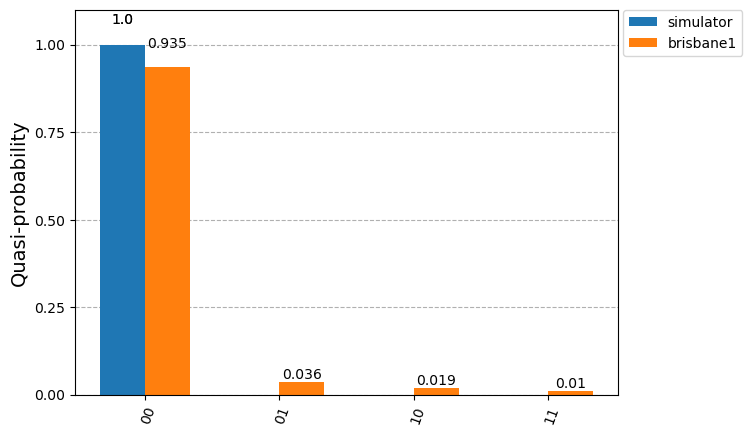

In [ ]:
# Load and plot the results
counts_brisbane1 = job_brisbane1.result()[0].data.c.get_counts()
plot_distribution([counts_simulator, counts_brisbane1], legend = ['simulator', 'brisbane1'] )


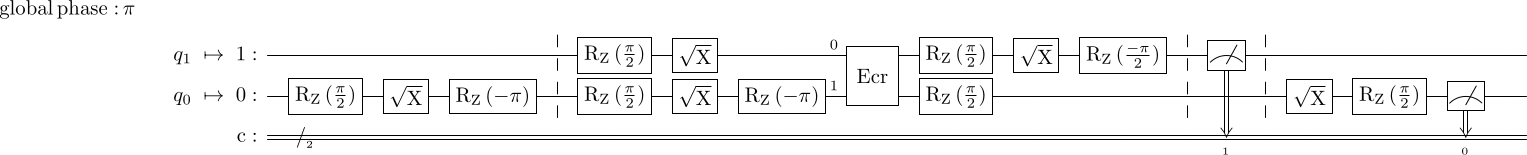

In [ ]:
# Why the error? Check out the transpiled circuit


isa_circ_qpe
.draw(reverse_bits=True, idle_wires=False, output="latex")

# 3-bit Quantum phase estimation

Estimate the eigenvalues of $U=R_y(\theta)$ where $\theta=\pi$.

In this case the eigenvalue associated to $|u\rangle =|+i\rangle$ is $\phi_u=0.j_1j_2j_3=0.110=0.75$. The one associated to $|u\rangle =|-i\rangle$ is $\phi_u=0.j_1j_2j_3=0.010=0.25$.

To prepare $|\psi\rangle=|-i\rangle$, use $R_{x}(\pi/2)|0\rangle$.

In [ ]:
#Enter theta as th
th=np.pi
threebitqpe = QuantumCircuit(4, 3)
threebitqpe.h(3)
threebitqpe.h(2)
threebitqpe.h(1)
# Prepares q3 into |psi>=|-i>
threebitqpe.rx(np.pi/2,0)

# Apply the c-U^{2^n} gates
threebitqpe.cry(th,3,0)
threebitqpe.cry(2*th,2,0)
threebitqpe.cry(4*th,1,0)
#
threebitqpe.h(3)
threebitqpe.h(2)
threebitqpe.h(1)
#

# Apply correction to q1
threebitqpe.crx(-np.pi/2,1,2)

# Apply correction to q0
threebitqpe.crx(-np.pi/4,1,3)
threebitqpe.crx(-np.pi/2,2,3)

# Note the assignment of qbits to cbits (I defined 4 qubits and 3 cbits!)
threebitqpe.measure([1,2,3],[0,1,2])
threebitqpe.draw(reverse_bits=True)

┌───┐              ┌───┐                              ┌──────────┐»
q_3: ───┤ H ├───────■──────┤ H ├──────────────────────────────┤ Rx(-π/4) ├»
        ├───┤       │      └───┘     ┌───┐        ┌──────────┐└────┬─────┘»
q_2: ───┤ H ├───────┼────────■───────┤ H ├────────┤ Rx(-π/2) ├─────┼──────»
        ├───┤       │        │       └───┘   ┌───┐└────┬─────┘     │      »
q_1: ───┤ H ├───────┼────────┼─────────■─────┤ H ├─────■───────────■──────»
     ┌──┴───┴──┐┌───┴───┐┌───┴────┐┌───┴────┐└───┘                        »
q_0: ┤ Rx(π/2) ├┤ Ry(π) ├┤ Ry(2π) ├┤ Ry(4π) ├─────────────────────────────»
     └─────────┘└───────┘└────────┘└────────┘                             »
c: 3/═════════════════════════════════════════════════════════════════════»
                                                                          »
«     ┌──────────┐   ┌─┐
«q_3: ┤ Rx(-π/2) ├───┤M├
«     └────┬─────┘┌─┐└╥┘
«q_2: ─────■──────┤M├─╫─
«         ┌─┐     └╥┘ ║ 
«q_1: ────┤M├──────╫──╫─
«         └╥┘      ║  ║ 
«q_0: ─────╫───────╫──╫─
«          ║       ║  ║ 
«c: 3/═════╩═══════╩══╩═
«          0       1  2

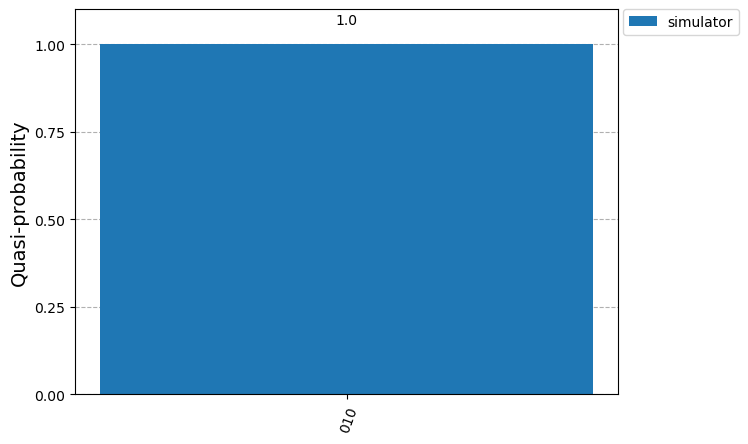

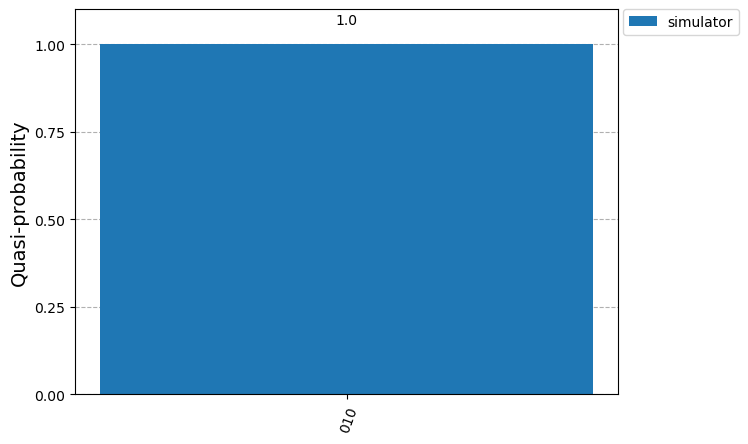

In [ ]:
# run on the simulator
job_simulator = backend_simulator.run(threebitqpe, shots=10000)
result_simulator = job_simulator.result()
counts_simulator = result_simulator.get_counts(threebitqpe)
plot_distribution([counts_simulator], legend=['simulator'])

The algorithm returned $j_1j_2j_3=010$ in all shots so it worked quite well in the simulator. I conclude that the code is right. Now let's try the real device:

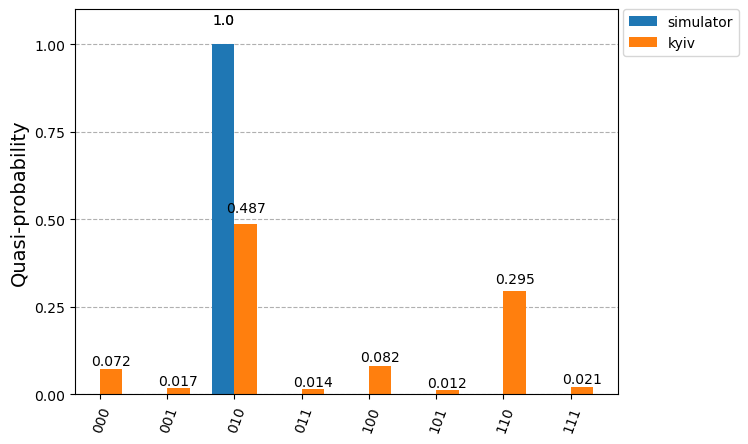

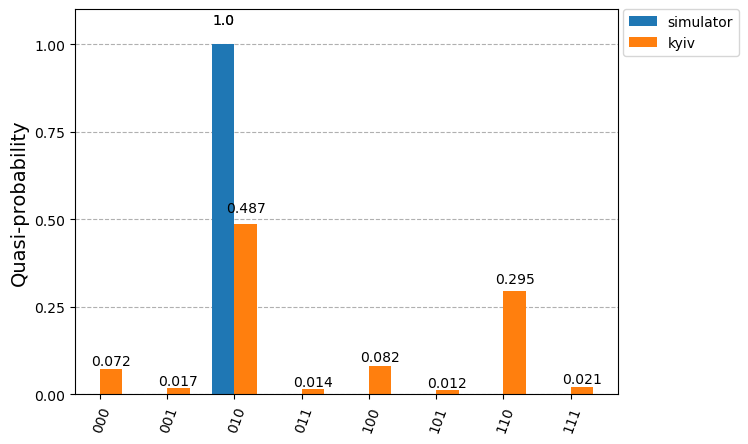

In [ ]:
pm = generate_preset_pass_manager(backend=backend_kyiv, optimization_level=1)
isa_circ_threebitqpe = pm.run(threebitqpe)
sampler_kyiv = SamplerV2(backend_kyiv)
job_kyiv_threebitqpe = sampler_kyiv.run([isa_circ_threebitqpe])
# Load and plot the results
counts_kyiv_threebitqpe = job_kyiv_threebitqpe.result()[0].data.c.get_counts()
plot_distribution([counts_simulator, counts_kyiv_threebitqpe], legend = ['simulator', 'kyiv'] )

In [ ]:
# From last year:

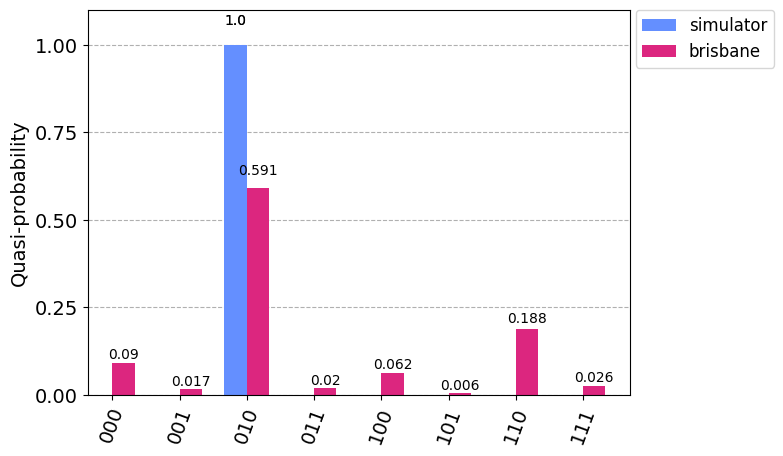

In [ ]:
# execute job on real device backend brisbane
transpiled_circ_real= transpile(circuit, backend=backend_brisbane)
job_brisbane = backend_brisbane.run(transpiled_circ_real, shots=1000)
result_brisbane = job_brisbane.result()
counts_brisbane = result_brisbane.get_counts(transpiled_circ_real)
plot_distribution([counts_simulator, counts_brisbane], legend=['simulator','brisbane'])

In [ ]:
#execute job on real device backend quebec
transpiled_circ_real= transpile(circuit, backend=backend_quebec)
job_quebec = backend_quebec.run(transpiled_circ_real, shots=1000)
result_quebec = job_quebec.result()
counts_quebec = result_quebec.get_counts(transpiled_circ_real)
plot_distribution([counts_simulator, counts_quebec], legend=['simul','quebec'])

## Results from last year (Santiago) for comparison:

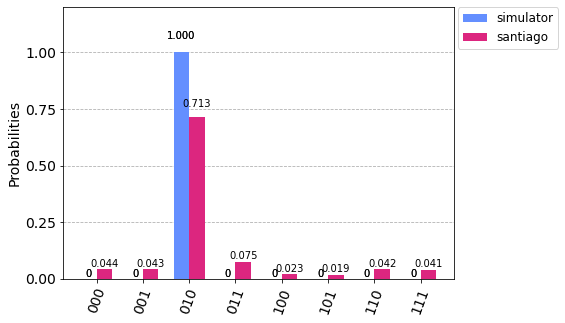

In [ ]:
counts_santiago  = job_santiago.result().get_counts(circuit)
plot_histogram([counts_simulator, counts_santiago], legend = ['simulator', 'santiago'] )

The highest peak is the `010` so we can say it worked. Look at the noise though! A slightly bigger circuit would barely work. 

In [ ]:
# Why the devices have so much noise? Actually there is a simple reason. The native gates in 
# santiago are:
print(backend_kyiv.configuration().supported_instructions)

['ecr', 'id', 'delay', 'measure', 'reset', 'rz', 'sx', 'x', 'if_else', 'for_loop', 'switch_case']


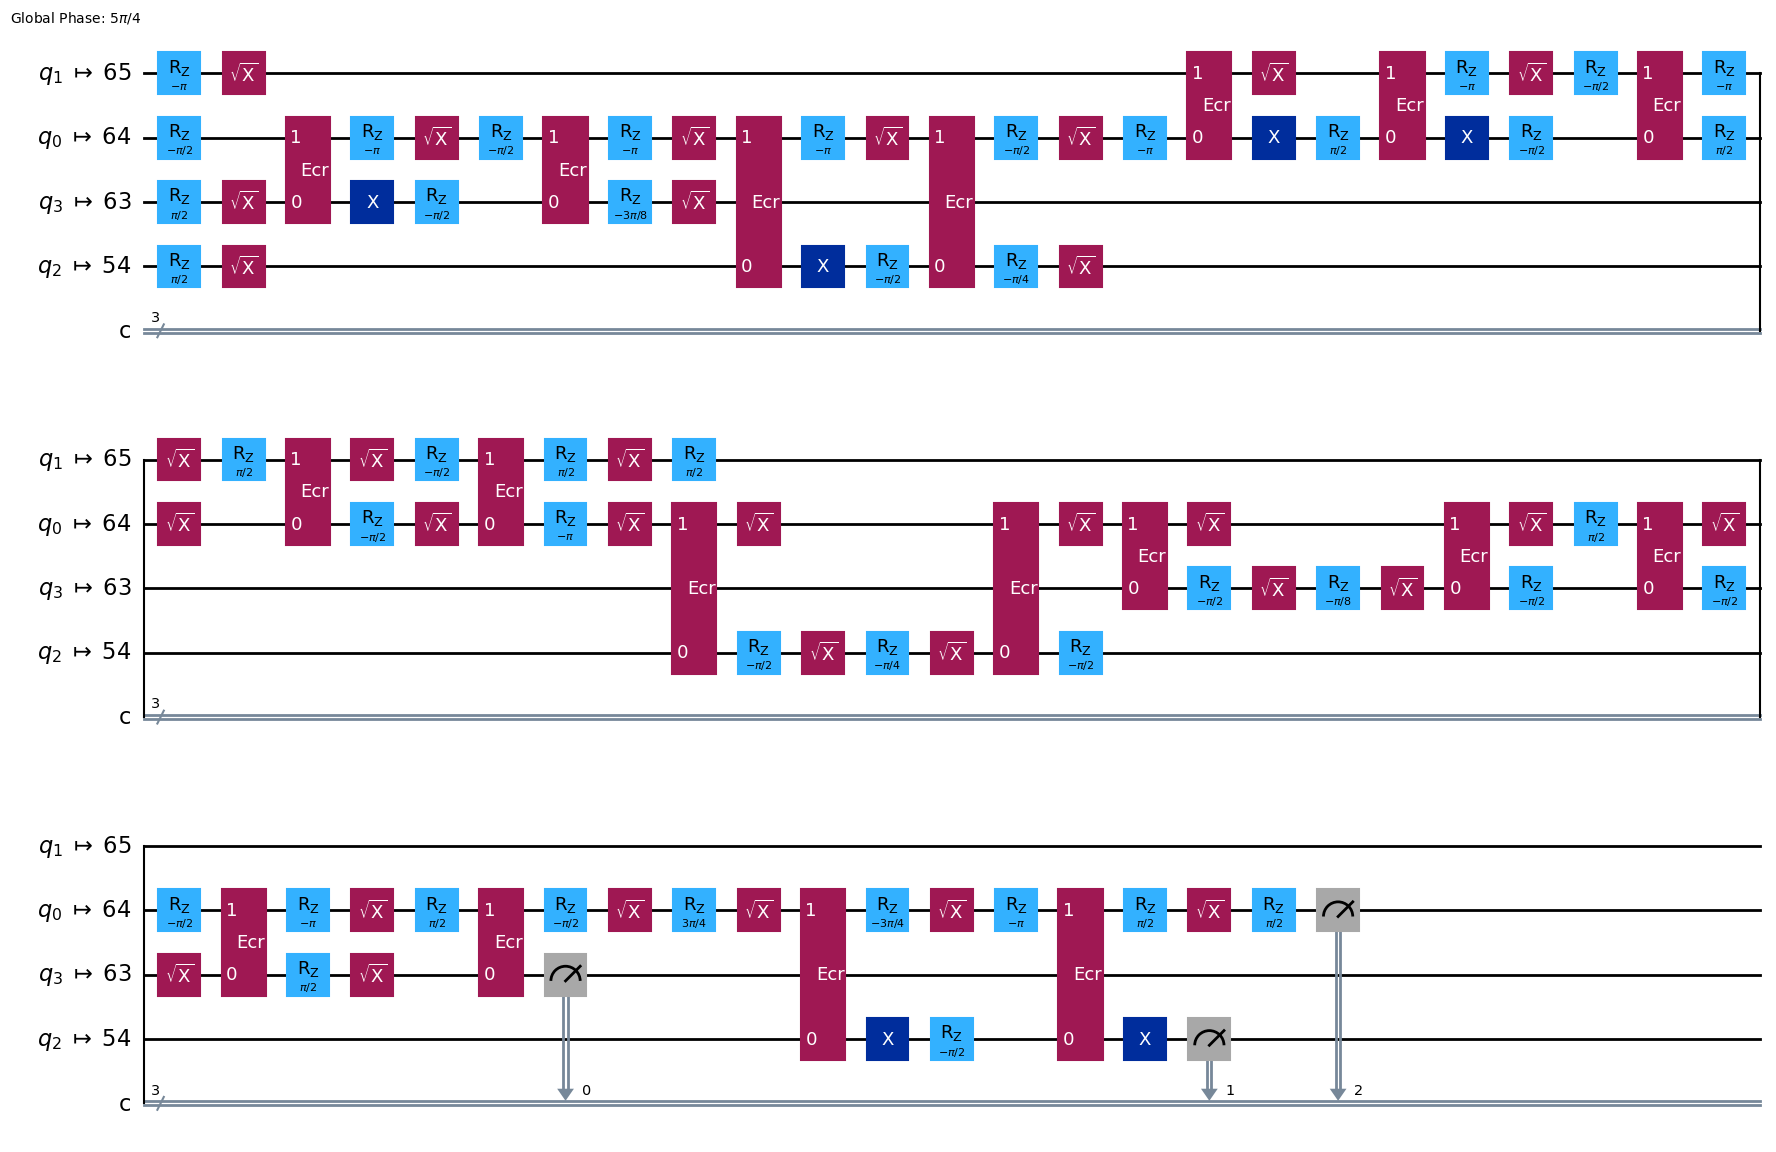

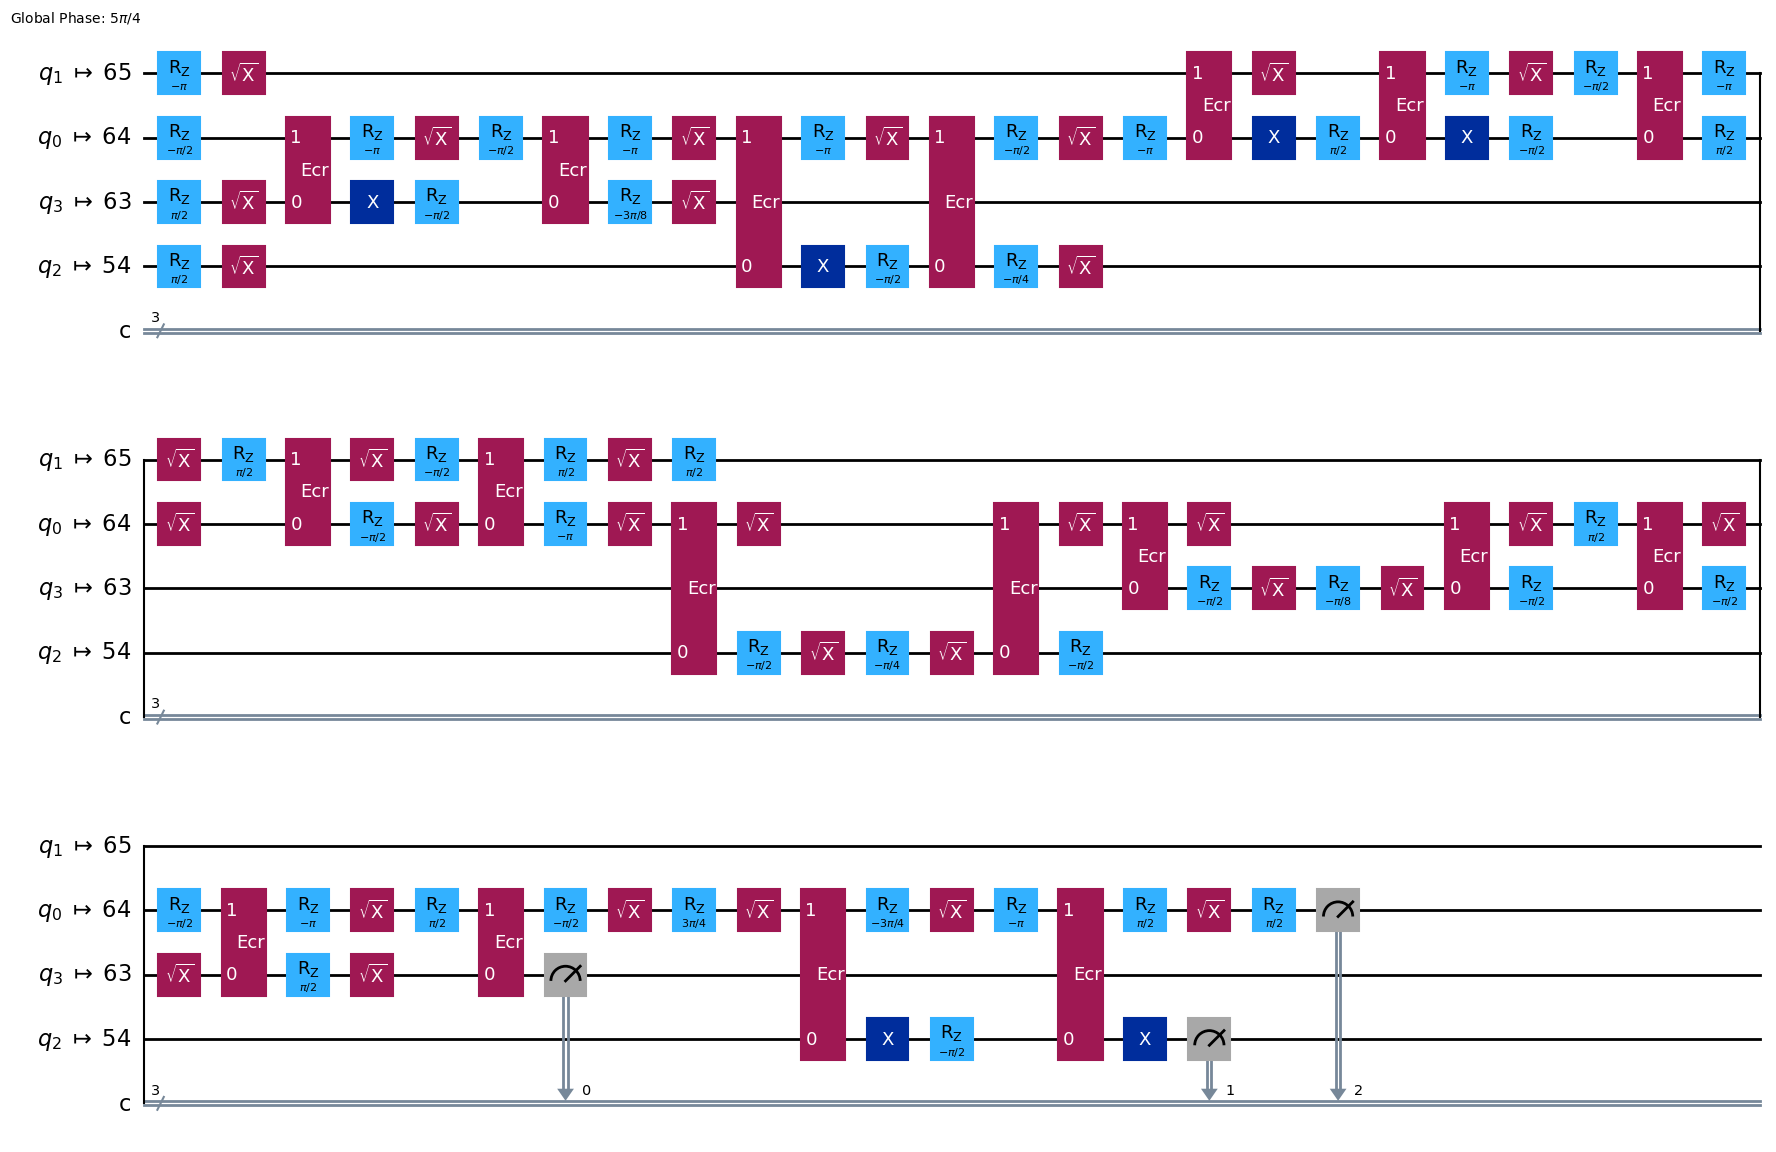

In [ ]:
# Why the error? Check out the transpiled circuit


isa_circ_threebitqpe.draw(reverse_bits=True, idle_wires=False, output="mpl")

# Classical simulation of quantum circuits, simulators available in Aer

# Two kinds of backends: 
# 1) Simulators that run LOCALLY on your machine, part of the Aer package
# 2) Actual quantum computers hosted on the quantum cloud

# Simulators that run locally: Several different methods.

In [ ]:
AerSimulator().available_methods()

('automatic',
 'statevector',
 'density_matrix',
 'stabilizer',
 'matrix_product_state',
 'extended_stabilizer',
 'unitary',
 'superop')

'automatic' chooses the best method. 

# Universal and exact simulators: 
'statevector', 'density_matrix', 'matrix_product_state'

These can handle up to 32 qubits depending on how powerful your local machine is. 

# 'matrix_product_state' 

Another exact and universal simulator is simulator_mps. It uses the matrix product state method  
 to compute circuits up to 100 qubits. This method is generally efficient when the entanglement is 
 "weak". If the entanglement is not weak, it may be very innefficient and computationally costly. 

# Approximate simulators that handle much more qubits. There are two kinds:

# Non-universal super-efficient simulator:
'stabilizer'

Provides an efficient simulation of circuits containing only a subset of gates called Clifford gates. 
The Clifford gates include CNOT, H, and S, but DOES NOT include T (so it's not universal!).
The Clifford circuits include some, but not all kinds of entangled states! Not all circuits can be
simulated by this. The stabilizer can simulate up to 5000 qubits!

# Universal "approximate" simulators:

extended_stabilizer approximates circuits by a clifford circuit, so it's universal but it's an 
approximation. It approximates the action of a quantum circuit using a ranked-stabilizer decomposition. 
The number of non-Clifford gates (e.g. number of T gates) determines the number of stabilizer terms. 
It can simulate up to 63 qubits. 

In [ ]:
# Define simulators to test them:

simulator_unitary = AerSimulator(method='unitary')
simulator_statevector = AerSimulator(method='statevector')
simulator_mps = AerSimulator(method='matrix_product_state')
simulator_extstab = AerSimulator(method='extended_stabilizer')

# Experiment with them for you to understand how they work!

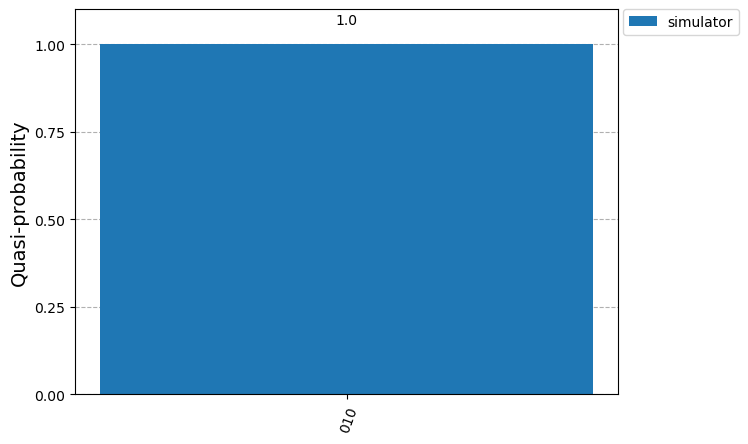

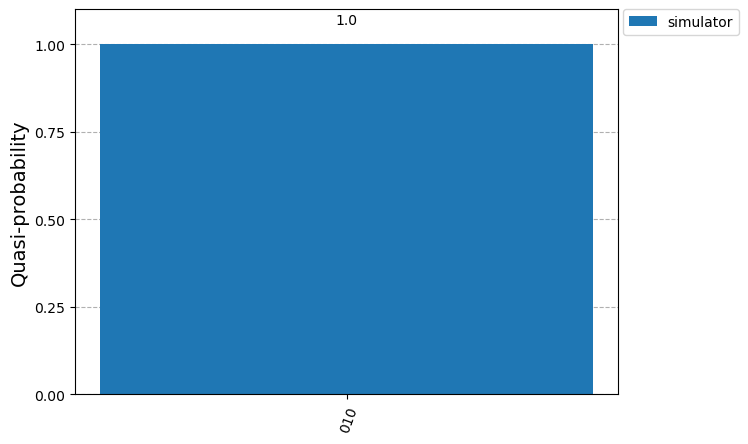

In [ ]:
job_simulator = simulator_statevector.run(threebitqpe, shots=10000)
result_simulator = job_simulator.result()
counts_simulator = result_simulator.get_counts(threebitqpe)
plot_distribution([counts_simulator], legend=['simulator'])